### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [4]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, finetuned: bool = True, verbose=0):
    assert config.model.pretrained, 'only pretrained models are allowed'
    if config.model.pretrained:
        if finetuned:
            print('init finetuned model')
            n_class = config.dataset.n_class
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=False,
            )
            model.head = nn.Linear(model.head.in_features, n_class)
        else:
            print('init pretrained-only model')
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=True,
            )
    model = model.to(device=device)
    if verbose:
        print(model)
        
    if finetuned:
        checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

        state_dict = checkpoint['model_state_dict']
        trimmed_keys = []
        for key in state_dict.keys():
            # remove prefix 'module.' for each key (in case of DataParallel)
            trimmed_keys.append(key[7:])
        trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

        model.load_state_dict(trimmed_state_dict)
    return model

In [5]:
from torchvision.datasets import CIFAR10, CIFAR100, SVHN, ImageNet
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

cifar10 = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
cifar10_test_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

cifar100 = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
cifar100_test_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

dataset_mean, dataset_std = [0.4377, 0.4438, 0.4728], [0.1980, 0.2010, 0.1970]
transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
svhn = SVHN(
    root=dataset_root, 
    split='test', 
    download=False, 
    transform=transform_test
)
svhn_test_dataloader = DataLoader(
    dataset=svhn, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])
imagenet = ImageNet(
    root='~/workspace/dataset/imagenet',
    split='val',
    download=None,
    transform=transform_test,
)

print(list(cifar10.class_to_idx.keys())[:10])
print(list(cifar100.class_to_idx.keys())[:10])
print(list(set(svhn.labels))[:10])
print(list(imagenet.class_to_idx.keys())[:10])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['tench', 'Tinca tinca', 'goldfish', 'Carassius auratus', 'great white shark', 'white shark', 'man-eater', 'man-eating shark', 'Carcharodon carcharias', 'tiger shark']


### Utility

In [6]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 4321

### Visualize Attention Masking

In [7]:
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor
from ood_with_vit.mim.attention_masking import AttentionMaskingHooker

In [8]:
import cv2

def apply_mask_on_img(img, mask):
    img_h, img_w, _ = img.shape
    mask = cv2.resize(mask, (img_h, img_w), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    masked_img = img * (1 - mask)
    return masked_img

In [16]:
from ood_with_vit.visualizer import ViTAttentionRollout

def visualize_attention_map(
    original_img, 
    rollout_attention_map,
    visualizer,
):
    mask = rollout_attention_map

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = visualizer.get_visualized_masks(original_img, mask)
    visualized_img = visualized_img[:, :, ::-1]
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()

def visualize_attention_masking(
    original_img,
    attention_mask,
):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = apply_mask_on_img(original_img, attention_mask)
    visualized_img = visualized_img.astype(np.int32)
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(attention_mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()

#### Pretrained-only model

In [64]:
model = initialize_vit_model(config, finetuned=False, verbose=1)
# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()

# add hooks for attention map extraction
attention_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.attention,
)
attention_extractor.hook()

# add hooks for attention masking
mask_method = 'max'
mask_ratio = 0.3
head_fusion = 'max'
discard_ratio = 0.9

attention_masking_hooker = AttentionMaskingHooker(
    config=config,
    model=model,
    attention_extractor=attention_extractor,
    patch_embedding_layer_name='patch_embed.norm',
    mask_method=mask_method,
    mask_ratio=mask_ratio,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
attention_masking_hooker.hook()

init pretrained-only model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): 

AssertionError: invalid mask methods

index:  4352
visualize original image and attention map


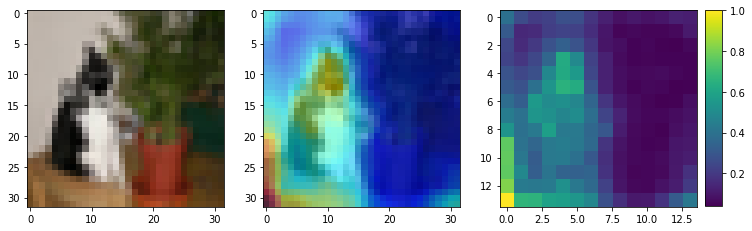

visualize masked image


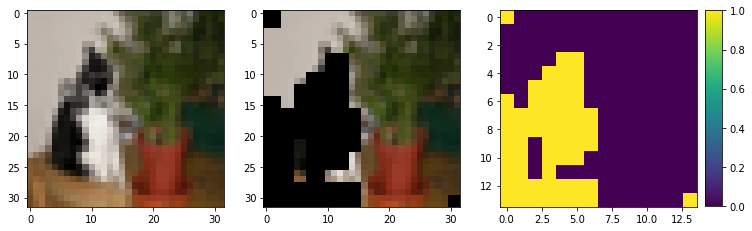

visualize masked image attention map


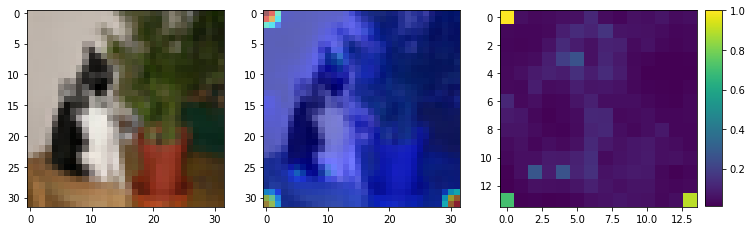

prediction before masking:     ('Japanese spaniel',), 7.7524, 0.3534
prediction after masking:     ('English foxhound',), 3.5324, 0.0205


In [40]:
from ood_with_vit.utils import compute_logits, compute_attention_maps

class_name = 'cat'
cls_idx = cifar10.class_to_idx[class_name]
img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
img_idx = random.choice(img_indices)
# img_idx = 8996

softmax = torch.nn.Softmax(dim=1)

print('index: ', img_idx)
original_img = cifar10.data[img_idx]
img, _ = cifar10[img_idx]
img = img.to(device)

visualizer = ViTAttentionRollout(
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)

attention_masking_hooker.switch_status('normal')
ori_logits = compute_logits(config, model, img.unsqueeze(0))
ori_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)
rollout_attention_map = visualizer.rollout(ori_attention_maps)[0]
ori_max_logit, ori_pred = ori_logits.max(axis=1)
ori_msp, _ = softmax(ori_logits).max(axis=1)

print('visualize original image and attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    rollout_attention_map=rollout_attention_map,
)

masks = attention_masking_hooker.generate_masks(img.unsqueeze(0))
print('visualize masked image')
visualize_attention_masking(
    original_img=cifar10.data[img_idx],
    attention_mask=masks[0],
)

attention_masking_hooker.switch_status('masking')
mask_logits = compute_logits(config, model, img.unsqueeze(0))
mask_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)
rollout_attention_map = visualizer.rollout(mask_attention_maps)[0]

print('visualize masked image attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    rollout_attention_map=rollout_attention_map,
)
mask_max_logit, mask_pred = mask_logits.max(axis=1)
mask_msp, _ = softmax(mask_logits).max(axis=1)

print(f'prediction before masking: \
    {imagenet.classes[ori_pred.item()]}, {ori_max_logit.item():.4f}, {ori_msp.item():.4f}')
print(f'prediction after masking: \
    {imagenet.classes[mask_pred.item()]}, {mask_max_logit.item():.4f}, {mask_msp.item():.4f}')


#### Finetuned model

In [13]:
model = initialize_vit_model(config, finetuned=True)
# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()

# add hooks for attention map extraction
attention_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.attention,
)

# add hooks for attention masking
mask_method = 'top_ratio'
mask_ratio = 0.3
mask_threshold = 0.5
head_fusion = 'max'
discard_ratio = 0.9

attention_masking_hooker = AttentionMaskingHooker(
    config=config,
    model=model,
    attention_extractor=attention_extractor,
    patch_embedding_layer_name='patch_embed.norm',
    mask_method=mask_method,
    mask_ratio=mask_ratio,
    mask_threshold=mask_threshold,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
attention_masking_hooker.hook()

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


#### In-distribution visualization

index:  8996
12 torch.Size([1, 3, 197, 197])
visualize original image and attention map


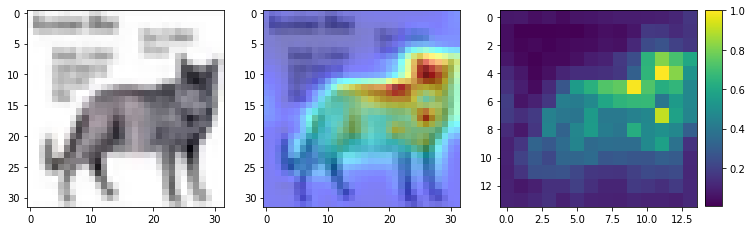

visualize masked image


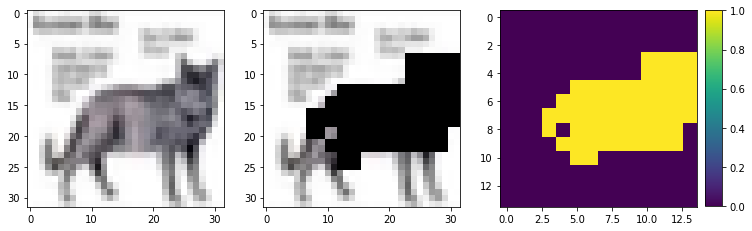

visualize masked image attention map


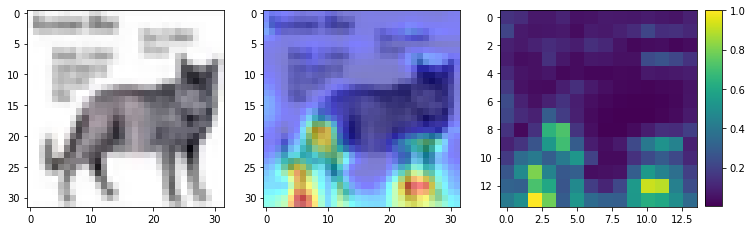

prediction before masking: cat, 9.1847, 9.1847
prediction after masking: horse, 3.9083, 1.2612


In [17]:
from ood_with_vit.utils import compute_logits, compute_attention_maps

class_name = 'cat'
cls_idx = cifar10.class_to_idx[class_name]
img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
img_idx = random.choice(img_indices)
img_idx = 8996

print('index: ', img_idx)
original_img = cifar10.data[img_idx]
img, _ = cifar10[img_idx]
img = img.to(device)

visualizer = ViTAttentionRollout(
    head_fusion='max',
    discard_ratio=0.9,
)

attention_masking_hooker.switch_status('normal')
ori_logits = compute_logits(config, model, img.unsqueeze(0))
attention_extractor.hook()
ori_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)
attention_extractor.remove_hooks()
print(len(ori_attention_maps), ori_attention_maps[0].shape)
rollout_attention_maps = visualizer.rollout(ori_attention_maps)
ori_max_logit, ori_pred = ori_logits.max(axis=1)

print('visualize original image and attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    rollout_attention_map=rollout_attention_maps[0],
    visualizer=visualizer,
)

masks = attention_masking_hooker.generate_masks(img.unsqueeze(0))
print('visualize masked image')
visualize_attention_masking(
    original_img=cifar10.data[img_idx],
    attention_mask=masks[0],
)

attention_masking_hooker.switch_status('masking')
mask_logits = compute_logits(config, model, img.unsqueeze(0))
attention_extractor.hook()
mask_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)
attention_extractor.remove_hooks()
rollout_attention_maps = visualizer.rollout(mask_attention_maps)

print('visualize masked image attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    rollout_attention_map=rollout_attention_maps[0],
    visualizer=visualizer,
)
mask_max_logit, mask_pred = mask_logits.max(axis=1)

print(f'prediction before masking: {cifar10.classes[ori_pred.item()]}, {ori_max_logit.item():.4f}, {ori_logits[0][cls_idx].item():.4f}')
print(f'prediction after masking: {cifar10.classes[mask_pred.item()]}, {mask_max_logit.item():.4f}, {mask_logits[0][cls_idx].item():.4f}')

In [41]:
from ood_with_vit.utils import compute_logits, compute_attention_maps

class_name = 'cat'
cls_idx = cifar10.class_to_idx[class_name]
img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
img_idx = random.choice(img_indices)
img_idx = 8996

print('index: ', img_idx)
original_img = cifar10.data[img_idx]
img, _ = cifar10[img_idx]
img = img.to(device)

imgs = torch.stack([img, img])
visualizer = ViTAttentionRollout(
    head_fusion=head_fusion,
    discard_ratio=discard_ratio
)

attention_masking_hooker.switch_status('normal')
ori_logits = compute_logits(config, model, imgs)
ori_attention_maps = compute_attention_maps(config, model, imgs, attention_extractor)
print(len(ori_attention_maps), ori_attention_maps[0].shape)
ori_max_logit, ori_pred = ori_logits.max(axis=1)
ori_attention_masks = visualizer.rollout(ori_attention_maps)

print('visualize original image and attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attention_mask=ori_attention_masks[0],
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attention_mask=ori_attention_masks[1],
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)

masks = attention_masking_hooker.generate_masks(imgs)
print('visualize masked image')
visualize_attention_masking(
    original_img=cifar10.data[img_idx],
    mask=masks[0],
)
visualize_attention_masking(
    original_img=cifar10.data[img_idx],
    mask=masks[1],
)

attention_masking_hooker.switch_status('masking')
mask_logits = compute_logits(config, model, imgs)
mask_attention_maps = compute_attention_maps(config, model, imgs, attention_extractor)
mask_attention_masks = visualizer.rollout(mask_attention_maps)

print('visualize masked image attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attention_mask=mask_attention_masks[0],
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attention_mask=mask_attention_masks[1],
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
mask_max_logit, mask_pred = mask_logits.max(axis=1)

print(f'prediction before masking: \
    {cifar10.classes[ori_pred[0].item()]}, {ori_max_logit[0].item():.4f}, {ori_logits[0][cls_idx].item():.3f}')
print(f'prediction before masking: \
    {cifar10.classes[ori_pred[1].item()]}, {ori_max_logit[1].item():.4f}, {ori_logits[1][cls_idx].item():.3f}')
print(f'prediction after masking: \
    {cifar10.classes[mask_pred[0].item()]}, {mask_max_logit[0].item():.4f}, {mask_logits[0][cls_idx].item():.4f}')
print(f'prediction after masking: \
    {cifar10.classes[mask_pred[1].item()]}, {mask_max_logit[1].item():.4f}, {mask_logits[1][cls_idx].item():.4f}')

index:  8996
12 torch.Size([2, 3, 197, 197])
visualize original image and attention map


TypeError: visualize_attention_map() got an unexpected keyword argument 'attention_mask'

index:  4561
torch.Size([2, 3, 224, 224])
visualize original image and attention map
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size([197, 197])
a: torch.Size([1, 197, 197])
indices: torch.Size([1, 34928])
I: torch.Size

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


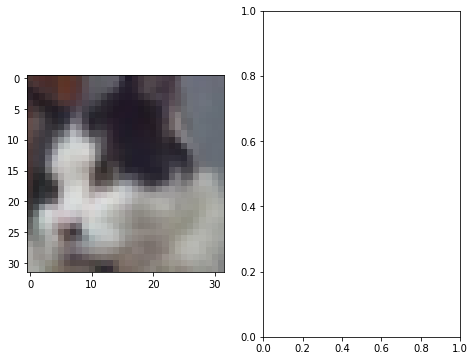

In [189]:
from ood_with_vit.utils import compute_logits, compute_attention_maps

class_name = 'cat'
cls_idx = cifar10.class_to_idx[class_name]
img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
img_idx = random.choice(img_indices)
# img_idx = 4710

print('index: ', img_idx)
original_img = cifar10.data[img_idx]
img, _ = cifar10[img_idx]
img = img.to(device)

img1, _ = cifar10[0]
img2, _ = cifar10[1]
imgs = torch.stack([img1, img2])

attention_masking_hooker.switch_status('normal')
ori_logits = compute_logits(config, model, imgs)
ori_attention_maps = compute_attention_maps(config, model, imgs, attention_extractor)
ori_max_logit, ori_pred = ori_logits.max(axis=1)

print('visualize original image and attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attn_weights=ori_attention_maps,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)

mask = attention_masking_hooker.generate_mask(img)
print('visualize masked image')
visualize_attention_masking(
    original_img=cifar10.data[img_idx],
    mask=mask,
)

attention_masking_hooker.switch_status('masking')
mask_logits = compute_logits(config, model, img.unsqueeze(0))
mask_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)

print('visualize masked image attention map')
visualize_attention_map(
    original_img=cifar10.data[img_idx],
    attn_weights=mask_attention_maps,
    head_fusion=head_fusion,
    discard_ratio=discard_ratio,
)
mask_max_logit, mask_pred = mask_logits.max(axis=1)

print(f'prediction before masking: {cifar10.classes[ori_pred.item()]}, {ori_max_logit.item():.4f}, {ori_logits[0][cls_idx].item():.3f}')
print(f'prediction after masking: {cifar10.classes[mask_pred.item()]}, {mask_max_logit.item():.4f}, {mask_logits[0][cls_idx].item():.4f}')

In [175]:
from ood_with_vit.utils import compute_logits, compute_attention_maps

class_name = 'bear'
cls_idx = cifar100.class_to_idx[class_name]
img_indices = np.where(np.array(cifar100.targets) == cls_idx)[0]
img_idx = random.choice(img_indices)
# img_idx = img_indices[i]

print('index: ', img_idx)
original_img = cifar100.data[img_idx]
img, _ = cifar100[img_idx]
img = img.to(device)

attention_masking_hooker.switch_status('normal')
ori_logits = compute_logits(config, model, img.unsqueeze(0))
ori_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)
ori_max_logit, ori_pred = ori_logits.max(axis=1)

print('visualize original image and attention map')
# visualize_attention_map(
#     original_img=cifar100.data[img_idx],
#     attn_weights=ori_attention_maps,
#     head_fusion=head_fusion,
#     discard_ratio=discard_ratio,
# )

mask = attention_masking_hooker.generate_mask(img)
print('visualize masked image')
# visualize_attention_masking(
#     original_img=cifar100.data[img_idx],
#     mask=mask,
# )

attention_masking_hooker.switch_status('masking')
mask_logits = compute_logits(config, model, img.unsqueeze(0))
mask_attention_maps = compute_attention_maps(config, model, img.unsqueeze(0), attention_extractor)

print('visualize masked image attention map')
# visualize_attention_map(
#     original_img=cifar100.data[img_idx],
#     attn_weights=mask_attention_maps,
#     head_fusion=head_fusion,
#     discard_ratio=discard_ratio,
# )
mask_max_logit, mask_pred = mask_logits.max(axis=1)

print(f'prediction before masking: {cifar10.classes[ori_pred.item()]}, {ori_max_logit.item():.4f}')
print(f'prediction after masking: {cifar10.classes[mask_pred.item()]}, {mask_max_logit.item():.4f}')

index:  3169
visualize original image and attention map
visualize masked image
visualize masked image attention map
prediction before masking: cat, 9.5374
prediction after masking: cat, 4.2271


### Visualize features

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from ood_with_vit.utils import compute_penultimate_features
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor
from ood_with_vit.mim.attention_masking import AttentionMaskingHooker

In [17]:
model = initialize_vit_model(config)
# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)

attention_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.attention,
)

mask_ratio = 0.2
attention_masking_hooker = AttentionMaskingHooker(
    config=config,
    model=model,
    attention_extractor=attention_extractor,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
attention_masking_hooker.hook()

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


In [21]:
# gather penultimate features
set_seed(seed)
num_samples = 20
num_class = 10

print('processing cifar10 samples...')
X_cifar10, y_cifar10 = [], []
cifar10_img_paths = []
cls_indices = random.sample(range(len(cifar10.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar10[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_cifar10.append(penultimate_features.squeeze().numpy())
        y_cifar10.append((cls_idx, cifar10.classes[cls_idx]))
        # CHW => HWC
        original_img_path = f'./assets/cifar10}/test/{i:05d}.jpg'
        original_img = cv2.imread(original_img_path)
        mask = simmim.get_mask()
        masked_img = apply_mask_on_img(original_img, mask)
        masked_img_path = f'./assets/{id_dataset_name}/test/masked/{i:05d}.jpg'
        cv2.imwrite(masked_img_path, masked_img)
        cifar10_img_paths.append(masked_img_path)

        # img_path = f'./assets/cifar10/test/{i:05d}.jpg'
        # # img_path = f'/assets/cifar10/test/{i:05d}.jpg'
        # cifar10_img_paths.append(img_path)
        
print('processing cifar100 samples...')
X_cifar100, y_cifar100 = [], []
cifar100_img_paths = []
cls_indices = random.sample(range(len(cifar100.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar100.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar100[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_cifar100.append(penultimate_features.squeeze().numpy())
        y_cifar100.append((cls_idx, cifar100.classes[cls_idx]))
        img_path = f'./assets/cifar100/test/{i:05d}.jpg'
        # img_path = f'/assets/cifar100/test/{i:05d}.jpg'
        cifar100_img_paths.append(img_path)

print('processing svhn samples...')
X_svhn, y_svhn = [], []
svhn_img_paths = []
cls_indices = random.sample(range(len(set(svhn.labels))), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(svhn.labels) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, target = svhn[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_svhn.append(penultimate_features.squeeze().numpy())
        y_svhn.append(str(cls_idx))
        img_path = f'./assets/svhn/test/{i:05d}.jpg'
        # img_path = f'/assets/svhn/test/{i:05d}.jpg'
        svhn_img_paths.append(img_path)

processing cifar10 samples...


100%|██████████| 20/20 [00:00<00:00, 95.76it/s]


processing cifar100 samples...


100%|██████████| 20/20 [00:00<00:00, 102.01it/s]


processing svhn samples...


100%|██████████| 20/20 [00:00<00:00, 103.06it/s]


#### Feature visualization by T-SNE

In [23]:
from ipywidgets import HTML, VBox

def interactive_plot(partitioned_info, fig, img_width=240, event="click") :
    """
    Make a plot react on hover or click of a data point and update a HTML preview below it.    
    """
    html = HTML("")
    fig = go.FigureWidget(data=fig.data, layout=fig.layout)

    if event == "hover" :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="{img_width}"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_hover(update)
    else :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="{img_width}"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_click(update)

    return VBox([fig, html])

In [33]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_cifar10)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar10)
df_embed = df_embed.assign(img=cifar10_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar10:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar10/test/02852.jpg'],
        …

In [34]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_cifar100)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar100)
df_embed = df_embed.assign(img=cifar100_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar100:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())

fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR100 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar100/test/03989.jpg'],
       …

In [35]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_svhn)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_svhn)
df_embed = df_embed.assign(img=svhn_img_paths)

partitioned_info, processed_labels = [], []
for label in y_svhn:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT SVHN T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/svhn/test/06430.jpg'],
           …

In [25]:
y_svhn = ['svhn' for _ in y_svhn]
X_all = X_cifar10 + X_svhn
y_all = y_cifar10 + y_svhn
img_all = cifar10_img_paths + svhn_img_paths
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_all)
n_samples = int(X_tsne.shape[0] / 2)
X_tsne_cifar10, X_tsne_svhn = X_tsne[:n_samples, :], X_tsne[n_samples:, :]

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_all)
df_embed = df_embed.assign(img=img_all)

partitioned_info, processed_labels = [], []
for label in y_all:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10, SVHN T-SNE',
)
interactive_plot(partitioned_info, fig, 64, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar10/test/05878.jpg'],
        …

#### Feature visualization by PCA

In [23]:
pca = PCA()
components = pca.fit_transform(X_cifar10)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar10)
df_embed = df_embed.assign(img=cifar10_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar10:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar10/test/47795.jpg'],
        …

In [17]:
pca = PCA()
components = pca.fit_transform(X_cifar100)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar100)
df_embed = df_embed.assign(img=cifar100_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar100:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR100 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar100/test/07143.jpg'],
       …

In [18]:
pca = PCA()
components = pca.fit_transform(X_svhn)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_svhn)
df_embed = df_embed.assign(img=svhn_img_paths)

partitioned_info, processed_labels = [], []
for label in y_svhn:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT SVHN PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/svhn/test/23880.jpg'],
           …

In [34]:
X_all = X_cifar10 + X_svhn
y_all = y_cifar10 + y_svhn
img_all = cifar10_img_paths + svhn_img_paths
pca = PCA()
components = pca.fit_transform(X_all)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_all)
df_embed = df_embed.assign(img=img_all)

partitioned_info, processed_labels = [], []
for label in y_all:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    # hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10, SVHN PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'hovertemplate': "class=(4, 'deer')<br>x=%{x}<br>y=%{y}<extra></ex…

In [93]:
X_all = X_cifar100 + X_svhn
y_all = y_cifar100 + y_svhn
img_all = cifar100_img_paths + svhn_img_paths
pca = PCA()
components = pca.fit_transform(X_all)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_all)
df_embed = df_embed.assign(img=img_all)

partitioned_info, processed_labels = [], []
for label in y_all:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title='ImageNet pretrained ViT CIFAR10, SVHN T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar100/test/04630.jpg'],
       …

### OOD detection baselines

In [7]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

### OOD detection by Mahalanobis

#### CIFAR10 vs. CIFAR100

In [72]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [73]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar10_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar10_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.97it/s]


covairance norms: [35.333, 56.15467, 24.710087, 24.760406, 39.9555, 33.052032, 34.579536, 37.751755, 43.906643, 69.12952]
covariance norm: 20.314365237275208


In [78]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar10_test_dataloader,
    out_of_dist_dataloader=cifar100_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]

id mean score: 185.77126 id variance: 5098.766
ood mean score: 296.23566 ood variance: 13700.672


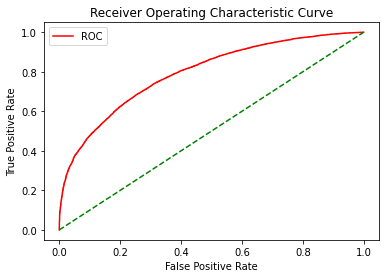

Mahalanobis AUROC score: 0.793445925


In [79]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

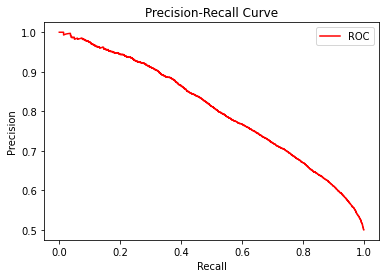

Mahalanobis AUPR score: 0.8042694946122347


In [80]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [81]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.7116


#### CIFAR100 vs. CIFAR10

In [82]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar100.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [83]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar100 = CIFAR100(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar100_train_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar100_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.99it/s]


covairance norms: [263.46378, 77.92307, 62.325638, 80.66709, 75.18534, 100.40797, 66.52207, 70.2855, 67.92541, 131.20055, 72.79468, 67.23096, 94.89134, 131.36543, 52.57952, 68.92815, 108.78612, 156.35555, 66.387245, 76.153435, 186.54181, 92.1108, 116.830666, 200.74992, 104.38893, 76.71766, 56.18107, 72.12981, 113.84088, 65.256004, 110.993095, 112.384674, 47.549763, 142.16095, 106.667244, 64.68393, 77.938354, 140.21097, 84.57663, 141.1265, 86.61233, 136.75073, 84.28827, 108.02133, 53.766808, 52.737347, 69.79799, 181.3637, 102.13129, 159.1394, 52.997185, 76.635635, 310.8027, 237.88107, 91.407074, 57.405407, 108.757965, 91.88912, 135.49464, 150.76845, 203.73753, 135.37445, 93.17572, 79.47289, 59.076694, 58.19088, 54.70186, 70.325676, 101.08861, 110.29933, 89.110725, 157.89583, 53.995583, 88.88261, 72.54234, 112.906395, 84.69865, 60.59433, 66.72352, 67.59271, 68.5114, 120.50207, 88.786995, 108.55526, 70.414055, 76.757904, 144.27342, 125.93828, 71.104095, 90.18949, 85.55628, 59.082256, 84.9

In [84]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar100_test_dataloader,
    out_of_dist_dataloader=cifar10_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


id mean score: 282.28717 id variance: 13077.243
ood mean score: 362.8451 ood variance: 16439.283


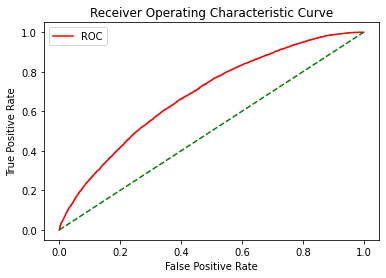

Mahalanobis AUROC score: 0.684721245


In [85]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

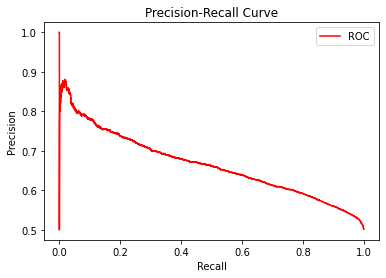

Mahalanobis AUPR score: 0.6653673709559564


In [86]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [87]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.801


#### CIFAR10 vs. SVHN

In [89]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [90]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10_train = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar10_train_dataloader = DataLoader(
    dataset=cifar10_train, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar10_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  4.01it/s]


covairance norms: [35.333, 56.15467, 24.710087, 24.760406, 39.9555, 33.052032, 34.579536, 37.751755, 43.906643, 69.12952]
covariance norm: 20.314365237275208


In [91]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar10_test_dataloader,
    out_of_dist_dataloader=svhn_test_dataloader,
)
print(len(id_ood_scores), len(ood_ood_scores))
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


processing out-of-distribution samples...


100%|██████████| 261/261 [00:14<00:00, 17.98it/s]


10000 10000
id mean score: 185.77122 id variance: 5098.7666
ood mean score: 198.51315 ood variance: 7935.3193


In [92]:
mahalanobis.compute_dataset_ood_score(cifar10_test_dataloader)
classes = set(mahalanobis.closest_classes)
for c in classes:
    tmd = np.array(mahalanobis.total_mahalanobis_distances)
    cc = np.array(mahalanobis.closest_classes)
    c_tmd = tmd[list(np.where(cc == c)[0])]
    n_samples = mahalanobis.closest_classes.count(c)
    print(f'{c}, {cifar10.classes[c]}: {n_samples}, mean: {c_tmd.mean()}, var: {c_tmd.var()}')

mahalanobis.compute_dataset_ood_score(svhn_test_dataloader)
classes = set(mahalanobis.closest_classes)
for c in classes:
    tmd = np.array(mahalanobis.total_mahalanobis_distances)
    cc = np.array(mahalanobis.closest_classes)
    c_tmd = tmd[list(np.where(cc == c)[0])]
    n_samples = mahalanobis.closest_classes.count(c)
    print(f'{c}, {cifar10.classes[c]}: {n_samples}, mean: {c_tmd.mean()}, var: {c_tmd.var()}')

100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


0, airplane: 1219, mean: 200.83541870117188, var: 5953.31494140625
1, automobile: 982, mean: 180.28318786621094, var: 5549.2197265625
2, bird: 1458, mean: 203.9126739501953, var: 4917.78173828125
3, cat: 1712, mean: 218.58245849609375, var: 5362.91015625
4, deer: 620, mean: 152.279052734375, var: 2285.1669921875
5, dog: 791, mean: 162.62451171875, var: 2515.4228515625
6, frog: 810, mean: 178.7567901611328, var: 4185.275390625
7, horse: 767, mean: 164.74615478515625, var: 4294.2294921875
8, ship: 916, mean: 177.46817016601562, var: 4754.640625
9, truck: 725, mean: 148.37918090820312, var: 3145.055908203125


100%|██████████| 261/261 [00:14<00:00, 17.99it/s]


0, airplane: 3865, mean: 277.4150695800781, var: 6065.61767578125
1, automobile: 12, mean: 330.41131591796875, var: 5214.02587890625
2, bird: 5620, mean: 122.05317687988281, var: 2861.732666015625
3, cat: 16308, mean: 205.9731903076172, var: 6601.2509765625
4, deer: 3, mean: 85.57693481445312, var: 152.88162231445312
5, dog: 46, mean: 155.63922119140625, var: 1258.68798828125
6, frog: 149, mean: 241.08758544921875, var: 8427.986328125
7, horse: 1, mean: 146.46051025390625, var: 0.0
8, ship: 28, mean: 277.72357177734375, var: 6558.03076171875


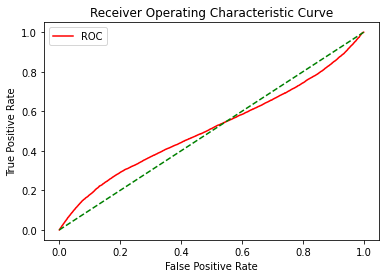

Mahalanobis AUROC score: 0.5133815625


In [56]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

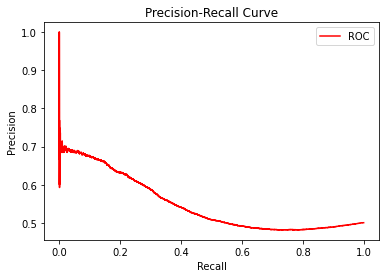

Mahalanobis AUPR score: 0.5485117350198137


In [57]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [58]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.9703


#### CIFAR100 vs. SVHN

In [11]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar100.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [12]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar100 = CIFAR100(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar100_train_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar100_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


covariance norm: 14.771052072849098


In [22]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar100_test_dataloader,
    out_of_dist_dataloader=svhn_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


processing out-of-distribution samples...


100%|██████████| 261/261 [00:18<00:00, 14.44it/s]

id mean score: 175.51826 id variance: 3052.4336
ood mean score: 132.59648 ood variance: 1724.3635


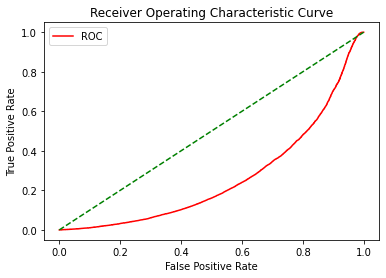

Mahalanobis AUROC score: 0.2627712738168408


In [23]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

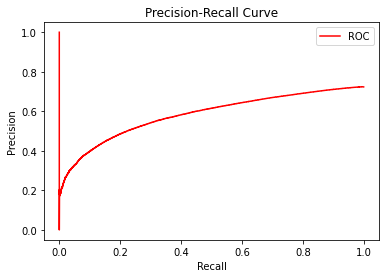

Mahalanobis AUPR score: 0.5826056984519462


In [24]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [18]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.9722
